# Pattern recognition work
+ Implement the C4.5 Decision Tree algorithm to classify the database provided
+ In the C4.5 algorithm, you must use entropy (information gain) as a criterion for choosing the nodes
+ Pruning is not necessary
+ Use K-fold cross validation with K = 10
+ You must choose the attributes that you find most convenient
+ At least 4 attributes must be used.

# Imports needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import warnings
warnings.filterwarnings('ignore')

# Load database

I created a link on github to make it easier to load the database, because if it couldn't make it difficult for my program to look for the file in the directories of a computer. In addition, I tried to name the columns because they were not characterized.

In [2]:
dados   = pd.read_csv('https://raw.githubusercontent.com/SamuelHericles/Arvore_decisao/master/wine.csv')
columns = {'Classe','Alcool','Acido malico','Cinza','Alcalinidade da cinza','Magnesio',
           'Fenois totais', 'Flavonoides','Fenois nao flavonoides','Proantocianidinas',
           'Intensidade da cor','Matiz','OD280/OD315 de vinhos diluidos','Prolina'}
dados.columns = columns
dados

,Classe,Flavonoides,Magnesio,Intensidade da cor,Alcalinidade da cinza,Fenois nao flavonoides,OD280/OD315 de vinhos diluidos,Alcool,Fenois totais,Cinza,Matiz,Acido malico,Prolina,Proantocianidinas
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


# Attribute choices
As stated in the work, the columns given already have the attributes to be chosen, so I chose the first four, which are:
+ Proline
+ Hue
+ Magnesio
+ Gray
+ Alcohol

There is no problem in choosing other attributes.

In [3]:
atributos = pd.DataFrame({})
atributos['Classe']  = dados['Classe'] 
atributos[dados.iloc[:,1].name]  = dados.iloc[:,1]
atributos[dados.iloc[:,2].name]  = dados.iloc[:,2]
atributos[dados.iloc[:,3].name]  = dados.iloc[:,3]
atributos[dados.iloc[:,4].name]  = dados.iloc[:,4]
atributos

,Classe,Flavonoides,Magnesio,Intensidade da cor,Alcalinidade da cinza
0,1,14.23,1.71,2.43,15.6
1,1,13.20,1.78,2.14,11.2
2,1,13.16,2.36,2.67,18.6
3,1,14.37,1.95,2.50,16.8
4,1,13.24,2.59,2.87,21.0
...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5
174,3,13.40,3.91,2.48,23.0
175,3,13.27,4.28,2.26,20.0
176,3,13.17,2.59,2.37,20.0


# As stated, we will remove a class
As advised by professor alexandre, we could remove a class from the base to make the job easier, but if I had a few more days for delivery I think I could do it for n classes.

In [4]:
atributos.drop(atributos.query('Classe==3').index,inplace=True)
atributos

,Classe,Flavonoides,Magnesio,Intensidade da cor,Alcalinidade da cinza
0,1,14.23,1.71,2.43,15.6
1,1,13.20,1.78,2.14,11.2
2,1,13.16,2.36,2.67,18.6
3,1,14.37,1.95,2.50,16.8
4,1,13.24,2.59,2.87,21.0
...,...,...,...,...,...
125,2,12.07,2.16,2.17,21.0
126,2,12.43,1.53,2.29,21.5
127,2,11.79,2.13,2.78,28.5
128,2,12.37,1.63,2.30,24.5


# Split training and test data with stratified Kfold shuffle

As he had commented to the professor about the use of random kfold (shuffle) he recommended me to deal with the proportion between classes, so I treated it like this:

+ In class 1 as there are 59 samples, I took 10% of them which gives ** 6 test samples ** and ** 53 training samples **
+ In class 2 as there are 71 samples I took 10% of them which gives ** 7 test samples ** and ** 64 training samples **

in all it gave 13 test samples chosen at random and 117 test samples.

The logic of the function below is:

1 - Divide the base between class 1 and 2 samples

2 - After debt, you take 10% of the sample indices at random

3 - The indices that are not in the 10% random go to the training base

4 - After doing the steps above, join the sleigh indices in a base called ** X ** and test called ** y **

In [5]:

def kfold_shuffle_estratificado(base):
    # @param base Base situation data
    # return X Training base
    # return y Test Base
    
    # Take the amount of data that class 1 has
    Classe1 = base.query('Classe==1')
    Classe1.reset_index(drop=True,inplace=True)

    # Take the amount of data that class 2 has
    Classe2 = base.query('Classe==2')
    Classe2.reset_index(drop=True,inplace=True)

    # Split class 1 test and training data
    index_teste_classe_1 = sorted(random.sample([i for i in Classe1.index.values],int(Classe1.shape[0]*.1)+1))
    X_classe_1 = Classe1.iloc[[i for i in Classe1.index if i not in index_teste_classe_1],:]
    y_classe_1 = Classe1.iloc[index_teste_classe_1,:]

    # Gathering training data and testing the classes
    index_teste_classe_2 = sorted(random.sample([i for i in Classe2.index.values],int(Classe2.shape[0]*.1)))
    X_classe_2 = Classe2.iloc[[i for i in Classe2.index if i not in index_teste_classe_2],:]
    y_classe_2 = Classe2.iloc[index_teste_classe_2,:]

    # Split class 2 test and training data
    X = X_classe_1
    y = y_classe_1

    X = X.append(X_classe_2,ignore_index=True)
    y = y.append(y_classe_2,ignore_index=True)
    return X,y

# Entropy

$H = - \sum_{i=1}^{n} {p_i(x)logp_i(x)}$

# Info Gain

$GH = H_{raiz} - \sum{pesos}*H_{folha}$

$Pesos = \frac{Nº amostras da folha}{Nº amostras da raiz}$


The functions below follow the entropy and gain equations above, it is worth mentioning that I used the math library because it has the resources to change the base of the logarithmic function because I put it into base 2.

In [6]:

def calcula_entropia(base):
    # @param base Entropy database
    # return entropy Entropy of the attribute base
    
    # Takes quantity of samples from class 1
    qt_am_1 = base.query('Classe==1').shape[0]
    
    # Takes quantity of samples from class 2
    qt_am_2 = base.query('Classe==2').shape[0]
    
    # Get the size of the attribute vector
    qt_base = base.shape[0]
    
    # Calculates the probability of each class 
    probabilidade_1  = qt_am_1/qt_base
    probabilidade_2  = qt_am_2/qt_base
    
    # Calculates entropy
    Entropia = -1*(probabilidade_1*math.log(probabilidade_1,2) + probabilidade_2*math.log(probabilidade_2,2))
    return Entropia


def ganho_de_informacao(folha,entropia_pai,entropia_filho):
    # @param sheet Sheet database
    # @param entropia_pai Entropy of the complete database
    # @param entropia_filho Entropy of the specific attribute
    # return GH Gain information 

    # Take the hair from each class and put it in this veto
    Pesos = [folha.query('Classe==1').shape[0]/folha.shape[0],folha.query('Classe==2').shape[0]/folha.shape[0]]
    
    # Calculates the information gain of the child node
    GH = (Pesos[0]*entropia_filho + Pesos[1]*entropia_filho) - entropia_pai
    return GH

# Database labeling by the median threshold of attributes

These two functions are the most important of the algorithm because they search for the best threshold based on the gain of information from the division of the attribute labels, the other divides the database of attributes to label it.
+ The function ** caca_limiar ** hunt for the best threshold that best labels the database, it takes the organization of the database in ascending order and resets the indexes of the vector to pocura. To make the algorithm faster, it checks if the class of two attributes is different to average the two and thus check the information gain with it. Finally, when taking a vector of all thresholds and their information gains, we order in a descending order based on the information gain to obtain the highest gain threshold and thus return this value in the function.
+ the function ** divide_ by the threshold ** takes the threshold entered in the function after that executes the function ** gain_of_information ** after the labeling of the database, finally returns the gain and information to the chosen threshold.

In [7]:

def caca_limiar(base,nome,entropia_pai):
    # @param base Database of an attribute
    # @param name Attribute name (feature)
    # @param entropia_pai Entropy from the original database
    # return GH_best Returns the best information gain for the given threshold
    # return limiar_best Returns the threshold for the best information gain
    
    valores = base.sort_values(nome)
    valores.reset_index(drop=True,inplace=True)
    GH_limiar = []
    for i in range(valores.shape[0]-1):
        if valores.Classe[i] != valores.Classe[i+1]:
            limiar = 0
            limiar = (valores.iloc[i,1]+valores.iloc[i+1,1])/2
            GH_limiar.append(divide_pelo_limar(base.iloc[:,1],entropia_pai,limiar))
    GH_best,limiar_best = sorted(GH_limiar,reverse=True)[0]
    return GH_best,limiar_best


def divide_pelo_limar(base,entropia_pai,limiar):
    # @param base Database of an attribute
    # @param entropia_pai Entropy of the situation database
    # return GH Gain attribute information
    # return threshold Threshold of attribute
    
    # Creates a dataframe that takes the class and value
    folha = pd.DataFrame(columns = {'Classe','Valor'})

    # Label test data from each attribute threshold
    for i in range(base.shape[0]):
         if base[i] > limiar:
                folha = folha.append({'Classe':1,'Valor':base[i]},
                                       ignore_index=True)
         elif base[i] <= limiar:
            folha = folha.append({'Classe':2,'Valor':base[i]},
                           ignore_index=True)

    # After labeling the attributes, entropy is calculated
    entropia_filho = calcula_entropia(folha)
    
    # Then gain information
    GH = ganho_de_informacao(folha,entropia_pai,entropia_filho)
    
    return GH,limiar

# The C4.5 descision tree algorithm
1. For each attribute:

     1.1 Order the attributes of the training base of the specific attribute;
    
     1.2 Determine the thresholds $ \ theta $;
    
     1.3 For each $ \ theta $ threshold, determine the information between $ \ theta $ and the attributes.
    
2. Choose the pairs [attribute, $ \ theta $] that offers the highest gain of information.


Source: slide available by the teacher.


+ The function ** rotula_rec ** labels recursively to create the database sheets. In the case that 4 attributes were chosen, a tree with 4 depth and $ 2 ^ 3 + 2 ^ 2 + 2 + 1 $ = 15 leaves is created.
+ The function ** arvore_de_decisao_c45 ** is the main function that uses all the above functions.

In [8]:

def rotula_rec(base,GHs,i):
    # @param base Dataframe of the specific attribute
    # @param GHs Dataframe of information gains and thresholds
    # @param i Dataframe position
    # return labels Vector of assigned labels

    rotulos = pd.DataFrame({})
    base.reset_index(drop=True,inplace=True)
    if i < GHs.shape[1]:
        for j in range(base.shape[0]):
            if base[GHs['Nome'][i]][j] >= GHs['Limiar'][i]:
                base['Classes_pred'][j] = 1
            else:
                base['Classes_pred'][j] = 2
    else:
        return
    rotulos = base.query('Classes_pred==1')
    rotulos = rotulos.append(base.query('Classes_pred==2'),ignore_index=True)
    
    rotula_rec(base.query('Classes_pred==1'),GHs,i+1)
    rotula_rec(base.query('Classes_pred==2'),GHs,i+1)
    
    return rotulos['Classes_pred']


def arvore_de_decisao_c45(X,y):
    # @param X Training base
    # @param y Test Base
    # return Model accuracy

    # Get the entropy from the database
    entropia_pai = calcula_entropia(X)
    
    # Creates the dataframe that stores earnings
    GHs = pd.DataFrame(columns = {'GH','Limiar','Nome'})
    
    # Get information data for each attribute
    for coluna in X.columns[1:]:
        df_aux = pd.DataFrame({})
        df_aux = atributos[['Classe',coluna]]
        GH,limiar = caca_limiar(df_aux,coluna,entropia_pai)  
        GHs = GHs.append({'GH':GH,'Limiar':limiar,'Nome':coluna},ignore_index=True)

    # Organizes the information gains in descending order
    GHs.sort_values('GH',ascending=False,inplace=True)
    GHs.reset_index(drop=True,inplace=True)

    # Remove the labels from the test stand
    y_pred = y.iloc[:,1:]
    y_pred['Classes_pred'] = 0
    y_pred['Classes_pred'] = rotula_rec(y_pred,GHs,0)
    return (sum(y_pred['Classes_pred'] == y['Classe'])/y.shape[0])*100

Execution of the algorithm

0
1
2
3
4
5
6
7
8
9


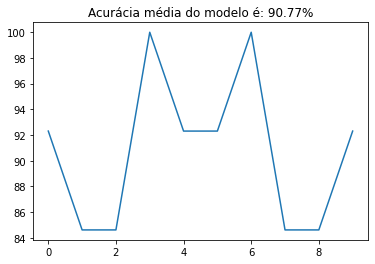

In [9]:
accs = []

for _ in range(10):
    print(_)
    X,y = kfold_shuffle_estratificado(atributos)
    accs.append(arvore_de_decisao_c45(X,y))

plt.title(f'Acurácia média do modelo é: {np.mean(accs).round(2)}%')
plt.plot(accs,'-')
plt.show()

# Teste sklearn

In [11]:
!pip install graphviz

In [12]:
from sklearn import tree
from sklearn.model_selection import cross_validate
import graphviz
from sklearn.tree import export_graphviz
from sklearn.model_selection import GroupKFold

clf = tree.DecisionTreeClassifier()
results = cross_validate(clf, X.iloc[:,1:], X['Classe'], cv=10, return_train_score=False)
cv = GroupKFold(n_splits=10)
def imprime_resultados(results):
    
    media = results['test_score'].mean()*100
    print('Acurácia média %.2f' % media)
imprime_resultados(results)

features = X.columns[1:]
clf.fit(X.iloc[:,1:], X['Classe'])
dot_data = export_graphviz(clf, out_file = None, filled = True,
                rounded = True,
                feature_names = features)


Acurácia média 93.33
